In [1]:
import torch
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)

PyTorch Version: 2.2.1
CUDA Available: True
CUDA Version: 12.1


In [2]:
# Create a random tensor and move it to GPU
x = torch.randn(3, 3).to('cuda')
print(x)

tensor([[ 0.8381, -1.6794, -0.6402],
        [-0.0074,  1.4635,  1.2262],
        [ 2.4932,  2.2686,  0.9864]], device='cuda:0')


In [3]:
import torch

# List all available GPUs
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPUs found")

GPU 0: NVIDIA GeForce RTX 3060


In [4]:
print(x.device)  # Prints device of tensor x
print(next(model.parameters()).device)  # Prints device of the first parameter of 'model'

cuda:0


NameError: name 'model' is not defined

Using the pre-trained model SamLowe/roberta-base-go_emotions

In [5]:
!pip install transformers

In [6]:
from transformers import pipeline

# top_k is set for getting top emotions, adjust according to the needs
top_k = 5
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", device=0, top_k=top_k)  # device=0 for GPU


In [7]:
test_sentences = [
    "I am not having a great day",  # Example of a negative sentiment
    "This is the best experience ever!",  # Example of a positive sentiment
    "I feel completely neutral about this",  # Example of a neutral sentiment
    "The service was incredibly disappointing",  # Example of a negative sentiment
    "I am thrilled with the product",  # Example of a positive sentiment
]

In [8]:
results = classifier(test_sentences)

In [9]:
#Testing the classifier
for sentence, emotion in zip(test_sentences, results):
    print(f"Sentence: '{sentence}'")
    print("Predicted emotions:")
    for e in emotion:
        print(f"  {e['label']}: {e['score']:.4f}")
    print("\n")  # Add a newline for better readability between results


Sentence: 'I am not having a great day'
Predicted emotions:
  disappointment: 0.4667
  sadness: 0.3985
  annoyance: 0.0681
  neutral: 0.0570
  disapproval: 0.0442


Sentence: 'This is the best experience ever!'
Predicted emotions:
  admiration: 0.9208
  joy: 0.1352
  approval: 0.0363
  gratitude: 0.0353
  excitement: 0.0303


Sentence: 'I feel completely neutral about this'
Predicted emotions:
  approval: 0.7029
  neutral: 0.2102
  disapproval: 0.0346
  realization: 0.0277
  annoyance: 0.0102


Sentence: 'The service was incredibly disappointing'
Predicted emotions:
  disappointment: 0.8594
  annoyance: 0.0968
  sadness: 0.0946
  disapproval: 0.0635
  neutral: 0.0492


Sentence: 'I am thrilled with the product'
Predicted emotions:
  excitement: 0.5939
  joy: 0.5281
  admiration: 0.0433
  neutral: 0.0361
  approval: 0.0264




Load the dataset

In [10]:
!pip install pandas

In [11]:
import pandas as pd

tokenized_data = pd.read_json('C:\\Users\\adnan\\Desktop\\Main_Dataset_Review1.json', lines=True)

In [12]:
tokenized_data.head()

,overall,vote,verified,reviewerID,asin,style,reviewerName,reviewText,summary,has_image,clean_reviewText,clean_summary,reviewText_length,clean_reviewText_length
0,1,0,True,A2KGOFRA94OWS9,B00GZOI1OC,Unknown,jlpoole520,"The part (the biggest part, the wheel) didn't ...","The part (the biggest part, the wheel) didn't ...",0,part biggest part wheel didnt fit buy new mach...,part biggest part wheel didnt fit,49,22
1,1,0,True,A1LIJY0J529J27,B00LHQYW0A,Unknown,John P,Incomplete order. Picture shows two heating e...,"Incomplete order, missing one heating element",0,incomplete order picture show two heating elem...,incomplete order missing one heating element,11,9
2,1,0,False,A3OMTDM4HR5XV9,B0050KMOM2,Unknown,steve combs,best bushing I've had in a long time,best bushing I've had in a long time,0,best bushing ive long time,best bushing ive long time,8,5
3,1,0,False,A10M3NOJHRC4F4,B001GD43RG,Unknown,Amazon Customer,"Biggest piece of s*** we ever bought, replaced...","Biggest piece of s*** we ever bought, replaced...",0,biggest piece ever bought replaced motor 4 tim...,biggest piece ever bought replaced motor,22,14
4,1,0,True,A3LF8E0TB9XWMZ,B00LJ5K82K,Unknown,Amazon Customer,dud shorted out element burned out the same da...,not very happy,0,dud shorted element burned daynot happy,happy,11,6


In [13]:
tokenized_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980383 entries, 0 to 1980382
Data columns (total 14 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   overall                  int64 
 1   vote                     int64 
 2   verified                 bool  
 3   reviewerID               object
 4   asin                     object
 5   style                    object
 6   reviewerName             object
 7   reviewText               object
 8   summary                  object
 9   has_image                int64 
 10  clean_reviewText         object
 11  clean_summary            object
 12  reviewText_length        int64 
 13  clean_reviewText_length  int64 
dtypes: bool(1), int64(5), object(8)
memory usage: 198.3+ MB


Load the tokenizer

In [14]:
from transformers import AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("SamLowe/roberta-base-go_emotions")


Tokenize and truncate the reviews

In [15]:
!pip install tqdm torch   

In [14]:
import torch
from transformers import AutoTokenizer
from tqdm.auto import tqdm  # for progress bars
import pandas as pd
from IPython.display import display
import ipywidgets as widgets

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("SamLowe/roberta-base-go_emotions")

# Load the dataset
tokenized_data = pd.read_json('C:\\Users\\adnan\\Desktop\\Main_Dataset_Review1.json', lines=True)

# Define a generator that processes text in smaller chunks
def batch_process(texts, tokenizer, max_length=512, batch_size=600):
    for i in tqdm(range(0, len(texts), batch_size), desc="Tokenizing"):
        batch = texts[i:i + batch_size]
        tokenized_output = tokenizer(batch, max_length=max_length, padding='max_length', truncation=True, return_tensors='pt')
        yield tokenized_output['input_ids'], tokenized_output['attention_mask']

# Set up the progress bar
num_batches = len(tokenized_data) // 600 + (1 if len(tokenized_data) % 600 > 0 else 0)
progress = widgets.IntProgress(value=0, min=0, max=num_batches, description='Processing:')
display(progress)

# Variables to store a sample for inspection
sample_input_ids = None
sample_attention_masks = None

# Process the text and move batches to GPU as needed
for input_ids, attention_masks in batch_process(tokenized_data['clean_reviewText'].tolist(), tokenizer):
    # Move tensors to GPU
    input_ids, attention_masks = input_ids.to('cuda'), attention_masks.to('cuda')

    # Optional: Perform some GPU-accelerated operations here, like model inference
    
    # For demonstration, store the first batch for later inspection
    if sample_input_ids is None:
        sample_input_ids = input_ids
        sample_attention_masks = attention_masks

    # Remember to clear GPU memory as needed
    del input_ids, attention_masks
    torch.cuda.empty_cache()  # Free up unused memory

    # Update the progress bar
    progress.value += 1

# After processing, you can inspect the first batch stored
print("Sample Input IDs:", sample_input_ids[:5])  # Just checking the first 5 entries
print("Sample Attention Masks:", sample_attention_masks[:5])  # Just checking the first 5 entries


IntProgress(value=0, description='Processing:', max=3301)

Tokenizing:   0%|          | 0/3301 [00:00<?, ?it/s]

Sample Input IDs: tensor([[    0,  7755,   934,  ...,     1,     1,     1],
        [    0,   179, 27527,  ...,     1,     1,     1],
        [    0,  7885,  2353,  ...,     1,     1,     1],
        [    0,  8527, 10403,  ...,     1,     1,     1],
        [    0,   417,  1906,  ...,     1,     1,     1]], device='cuda:0')
Sample Attention Masks: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')


In [15]:
assert progress.value == progress.max, "Tokenization incomplete: Not all batches were processed."

In [16]:
# Sample check for the first few tokenized outputs
sample_input_ids = input_ids[:5]  # Assuming 'input_ids' is still in your namespace from the last batch processed
sample_attention_masks = attention_masks[:5]  # Assuming 'attention_masks' is still in your namespace

print("Sample Input IDs:", sample_input_ids)
print("Sample Attention Masks:", sample_attention_masks)


NameError: name 'input_ids' is not defined

In [17]:
# Choose a sample from the batch (e.g., the first one)
sample_index = 0  # Index of the sample to check

# Decode the tokens to text
decoded_text = tokenizer.decode(sample_input_ids[sample_index], skip_special_tokens=True)

# Print the original text and the decoded text for comparison
original_text = tokenized_data['clean_reviewText'].iloc[sample_index]
print("Original Text:", original_text)
print("Decoded Text:", decoded_text)


Original Text: part biggest part wheel didnt fit buy new machine mechanic fixed dryer soooooo irritating washer bit complex wish luck effort congratulation succeed
Decoded Text: part biggest part wheel didnt fit buy new machine mechanic fixed dryer soooooo irritating washer bit complex wish luck effort congratulation succeed


In [18]:
# Check lengths of input_ids to ensure they respect the max_length
print("Length of first input_ids:", sample_input_ids[sample_index].shape[1])

# Confirm that attention masks correctly identify padding (zeros at the end)
num_padding_tokens = (sample_attention_masks[sample_index] == 0).sum().item()
print("Number of padding tokens in the attention mask:", num_padding_tokens)


IndexError: tuple index out of range

Lets make sure that the model and tokenizer are correctly set up for inference

In [19]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

#Load the pretrained model and tokenizer
model_name = "SamLowe/roberta-base-go_emotions"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=28)  # Adjust num_labels if different
model.to('cuda')  # Move the model to GPU
model.eval()  # Set the model to evaluation mode

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

 Now lets define a function to get predictions from the model

In [20]:
#import torch
#from torch.utils.data import TensorDataset, DataLoader
#
#def get_top_emotions(texts, tokenizer, model, batch_size=32):
#    #Tokenize all texts
#    tokens = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
#    dataset = TensorDataset(tokens['input_ids'], tokens['attention_mask'])
#    dataloader = DataLoader(dataset, batch_size=batch_size)

#    # Container for all the batch predictions
#    all_predictions = []

#    # Disable gradient calculations and perform inference
#    with torch.no_grad():
#        for batch in dataloader:
#            batch = tuple(t.to('cuda') for t in batch)  # Move the batch to GPU
#            inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
#            outputs = model(**inputs)
#            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
#            all_predictions.extend(predictions.detach().cpu().numpy())
#
#    # Convert predictions to list of top 5 emotions
#    top5_emotions = []
#    for prediction in all_predictions:
#        top5_idx = prediction.argsort()[-5:][::-1]  # Get indices of top 5 values
#        top5_emotions.append([tokenizer.decode([idx], skip_special_tokens=True) for idx in top5_idx])

#    return top5_emotions

In [21]:
#top_emotions = get_top_emotions(tokenized_data['clean_reviewText'].tolist(), tokenizer, model, batch_size=32)
#tokenized_data['review_emotions'] = top_emotions

Due to the above issue we will use a chunk processing function

Update to get_top_emotions function for the purpose of optimizing for memory usage

In [22]:
import torch

print("PyTorch version:", torch.__version__)
print("Is CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of GPUs available:", torch.cuda.device_count())
print("Current CUDA Device:", torch.cuda.current_device())
print("CUDA Device Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

PyTorch version: 2.2.1
Is CUDA available: True
CUDA version: 12.1
Number of GPUs available: 1
Current CUDA Device: 0
CUDA Device Name: NVIDIA GeForce RTX 3060


Benchmark Data Transfer Speeds

In [23]:
import numpy as np
import time

# Create a large tensor
size = 100000000  # Adjust size based on your system's capabilities
data = torch.FloatTensor(np.random.rand(size))

# Measure CPU to GPU transfer time
start_time = time.time()
data_gpu = data.to('cuda')
print("Time to transfer data from CPU to GPU:", time.time() - start_time, "seconds")

# Measure GPU to CPU transfer time
start_time = time.time()
data_cpu = data_gpu.to('cpu')
print("Time to transfer data from GPU to CPU:", time.time() - start_time, "seconds")

Time to transfer data from CPU to GPU: 0.1623079776763916 seconds
Time to transfer data from GPU to CPU: 0.17499852180480957 seconds


In [24]:
#Simple GPU computation test
start_time = time.time()
result = data_gpu * 2  # Simple multiplication operation
torch.cuda.synchronize()  # Wait for GPU to finish
print("Time for GPU computation:", time.time() - start_time, "seconds")

Time for GPU computation: 0.015007257461547852 seconds


Lets retry the training process all over again 

In [25]:
# Run Python garbage collection
import gc

gc.collect()

510

In [26]:
 # Delete large temporary variables
torch.cuda.empty_cache()

In [27]:
import os
import psutil

# Function to print memory usage
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Memory Usage: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Function to release memory by deleting variables
def release_memory(vars_to_delete):
    for var in vars_to_delete:
        if var in globals():
            del globals()[var]
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Before starting the model training, print memory usage
print_memory_usage()

Memory Usage: 10357.93 MB


In [28]:
import sys

#Function to print memory usage of variables in the global space
def print_memory_usage_of_globals():
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in globals().items()),
                            key= lambda x: -x[1])[:10]:
        print(f"{name:>30}: {size:>10} bytes")


# Call the function to print out the memory usage
print_memory_usage_of_globals()

                tokenized_data: 2593193354 bytes
                           ___:       4109 bytes
                           _12:       4109 bytes
                          _i14:       2205 bytes
                          tqdm:       2008 bytes
                          _i20:       1316 bytes
                 AutoTokenizer:       1064 bytes
AutoModelForSequenceClassification:       1064 bytes
                            _i:        591 bytes
                          _i27:        591 bytes


In [29]:
variables_to_delete = ['_iii', '_i55',  'In', '_ih', 'AutoModelForSequenceClassification', 'autocast', ]

#Release memory
release_memory(variables_to_delete)

#Print the memory usage
print_memory_usage()

Memory Usage: 10357.93 MB


In [15]:
%reset -f

Lets test the results by just running the pretrained model over 100k reviews

In [31]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.auto import tqdm

# Set computing device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the function to get the top emotions from texts
def get_top_emotions(texts, tokenizer, model, batch_size=64):
    model.to(device)  # Ensure the model is on the right device
    all_predictions = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        batch_texts = texts[i:i + batch_size]
        tokens = tokenizer(batch_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
        tokens = {k: v.to(device) for k, v in tokens.items()}  # Move tokenized data to the device
        with torch.no_grad():
            outputs = model(**tokens)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
            all_predictions.extend(predictions.detach().cpu().numpy())  # Move predictions back to CPU
    top5_emotions = []
    for prediction in all_predictions:
        top5_idx = np.argsort(prediction)[-5:][::-1]
        top5_emotions.append([tokenizer.decode([idx], skip_special_tokens=True) for idx in top5_idx])
    return top5_emotions

# Initialize model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("SamLowe/roberta-base-go_emotions")
model = AutoModelForSequenceClassification.from_pretrained("SamLowe/roberta-base-go_emotions")
model.eval()  # Still set the model to evaluation mode

# Load dataset and prepare subset
tokenized_data = pd.read_json('C:\\Users\\adnan\\Desktop\\Main_Dataset_Review1.json', lines=True)
subset = tokenized_data.sample(n=100000, random_state=1)

# Process the subset directly
subset['review_emotions'] = get_top_emotions(subset['clean_reviewText'].tolist(), tokenizer, model, batch_size=100)

# Save final results
output_path = 'sample_emotion_results.json'
subset.to_json(output_path, orient='records', lines=True)

Processing batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Understanding the above issue I have added error handling for length mismatch, for the sake of progress monitoring, and for batch processing of the get_top_emotions

In [52]:
import gc
import torch

# Clear PyTorch's cache
torch.cuda.empty_cache()

# Run Python garbage collection
gc.collect()

1539

In [32]:
import pandas as pd

# Load the JSON results into a DataFrame
try:
    # Adjust the path if the file is not in the current working directory
    emotion_results_df = pd.read_json('sample_emotion_results.json', lines=True)
except Exception as e:
    emotion_results_df = str(e)

emotion_results_df

,overall,vote,verified,reviewerID,asin,style,reviewerName,reviewText,summary,has_image,clean_reviewText,clean_summary,reviewText_length,clean_reviewText_length,review_emotions
0,4,0,True,A23ZYWM2WHJI2M,B00V54LQO4,Unknown,OneMoreThing,I paid completely out of pocket for this and h...,So far so good,0,paid completely pocket reimbursed review ive 2...,far good,145,60,"[�, ., , "", a]"
1,3,0,True,A8Q9L444GXGR4,B00H29ETXQ,Unknown,Kindle Customer,I am only giving 3 stars because it arrivered ...,But like previous review not large at,0,giving 3 star arrivered early like previous re...,like previous review large,18,9,"[�, ., "", , The]"
2,5,0,True,A3KD2620N3V9H3,B006OQJK28,Unknown,Niffuts,Product arrived on time and as described.,Five Stars,0,product arrived time described,five star,7,4,"[�, ., "", for, The]"
3,5,22,True,A1ZX675046PIY5,B0142F5M1U,"{'Color:': ' Steel shaft', 'Hand Orientation:'...",Jeffrey,If you can't hit this quit golf.,Five Stars,0,cant hit quit golf,five star,7,4,"[ a, , �, , of]"
4,5,3,True,AGYV9LBTHLN0V,B0002JOZNM,{'Size:': ' 10-Foot'},Matthew England,A product you won't find in any store due to i...,$20 Solution to a $100 Problem! Fantastic!,0,product wont find store due length thats preci...,20 solution 100 problem fantastic,69,35,"[�, a, ., "", ]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,3,0,True,A2FKPKT8YYMGTR,B013QTQRRG,Unknown,Lizeth Ortiz,"The color is brown,\nIt is not that pretty as ...",It is not that pretty as it looks like in the ...,0,color brown pretty look like picture,pretty look like picture,16,6,"[, ., �, 's, ""]"
99996,5,11,True,A329IE6128J15W,B00NOVOTJ0,Unknown,Jacob Carlson,I bought this set on sale for around 100 dolla...,Great Value! Comparible to Other Name Brands a...,0,bought set sale around 100 dollar price compar...,great value comparible name brand used wide va...,169,89,"[�, ., , "", 's]"
99997,5,0,True,A21K5RU7GV3F0P,B00QQ3WN0K,Unknown,Yvette V. Rodriguez,Works great!,GOOD BUY - WORKS GREAT,0,work great,good buy work great,2,2,"[, ., �, on, a]"
99998,4,0,False,AQ2UN38CMK119,B01GSAEZ5G,"{'Size:': ' 4 Pouches', 'Flavor:': ' Berry'}",P. Mann,I was nervous about this product since I have ...,Tastes just like other yogurt,0,nervous product since always yogurt cold delib...,taste like yogurt,167,81,"[�, ., "", The, ]"


In [33]:
emotion_results_df.head(20)

,overall,vote,verified,reviewerID,asin,style,reviewerName,reviewText,summary,has_image,clean_reviewText,clean_summary,reviewText_length,clean_reviewText_length,review_emotions
0,4,0,True,A23ZYWM2WHJI2M,B00V54LQO4,Unknown,OneMoreThing,I paid completely out of pocket for this and h...,So far so good,0,paid completely pocket reimbursed review ive 2...,far good,145,60,"[�, ., , "", a]"
1,3,0,True,A8Q9L444GXGR4,B00H29ETXQ,Unknown,Kindle Customer,I am only giving 3 stars because it arrivered ...,But like previous review not large at,0,giving 3 star arrivered early like previous re...,like previous review large,18,9,"[�, ., "", , The]"
2,5,0,True,A3KD2620N3V9H3,B006OQJK28,Unknown,Niffuts,Product arrived on time and as described.,Five Stars,0,product arrived time described,five star,7,4,"[�, ., "", for, The]"
3,5,22,True,A1ZX675046PIY5,B0142F5M1U,"{'Color:': ' Steel shaft', 'Hand Orientation:'...",Jeffrey,If you can't hit this quit golf.,Five Stars,0,cant hit quit golf,five star,7,4,"[ a, , �, , of]"
4,5,3,True,AGYV9LBTHLN0V,B0002JOZNM,{'Size:': ' 10-Foot'},Matthew England,A product you won't find in any store due to i...,$20 Solution to a $100 Problem! Fantastic!,0,product wont find store due length thats preci...,20 solution 100 problem fantastic,69,35,"[�, a, ., "", ]"
5,5,0,True,A57MDPBRO9PA,B01DKQAXC0,{'Scent Name:': ' Aloe Delight'},ziggy,This stuff is MAGIC. I have a very physical jo...,MAGIC.,0,stuff magic physical job often follow roller d...,magic,49,24,"[�, ., a, "", ]"
6,4,0,True,A1HNNQCCD1M069,B012Z7IHHI,{'Color:': ' C011'},Em,"This brand is good for the price, but not as g...",Well worth it for the price.,0,brand good price good quality expensive stuff ...,well worth price,74,33,"[., , �, The, a]"
7,4,0,True,A1HUH1FYCL6SVG,B00DNNM9WI,"{'Size:': ' X-Large', 'Color:': ' Columbia Grey'}",seandigity,Your paying for that Columbia name here. Jacke...,Paying for the name.,0,paying columbia name jacket paper thin wouldnt...,paying name,44,21,"[�, ., , The, ""]"
8,5,0,True,A1ZMGG2S47JCV,B00K1D5UYW,Unknown,MandM,Love this set and younger double brushes.,Five Stars,0,love set younger double brush,five star,7,5,"['s, , ., �, �]"
9,2,4,False,A1QXE7OX7MSL2H,B013QN8NK6,{'Style Name:': ' 3 Tiered Server'},M. Gondek,Note that this review is for the 3-tiered serv...,3-tiered Server doesn't assemble,0,note review 3tiered server piece set dont see ...,3tiered server doesnt assemble,348,165,"[ The, �, and, a, of]"


Due to the above errors we will test it on 10 reviews first to see if we are getting a response

In [34]:
import torch 
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification

#Set computing of the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Function to get the top emotions from the texts
def get_top_emotions(texts, tokenizer, model):
    model.to(device)  # Ensure the model is on the right device
    tokens = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
    tokens = {k: v.to(device) for k, v in tokens.items()}
    with torch.no_grad():
        outputs = model(**tokens)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        all_predictions = predictions.detach().cpu().numpy()

    top5_emotions = []
    for prediction in all_predictions:
        top5_idx = np.argsort(prediction)[-5:][::-1]
        top5_emotions.append([tokenizer.decode([idx], skip_special_tokens=True) for idx in top5_idx])
    return top5_emotions

# Initialize model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("SamLowe/roberta-base-go_emotions")
model = AutoModelForSequenceClassification.from_pretrained("SamLowe/roberta-base-go_emotions")
model.eval()

# Load dataset and prepare subset
tokenized_data = pd.read_json('C:\\Users\\adnan\\Desktop\\Main_Dataset_Review1.json', lines=True)
subset = tokenized_data.iloc[:10]  # Selecting the first 10 reviews

# Process the subset directly
subset['review_emotions10'] = get_top_emotions(subset['clean_reviewText'].tolist(), tokenizer, model)

# Save final results
output_path = 'sample10_emotion_results.json'
subset.to_json(output_path, orient='records', lines=True)

C:\Users\adnan\AppData\Local\Temp\ipykernel_7872\899889240.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['review_emotions10'] = get_top_emotions(subset['clean_reviewText'].tolist(), tokenizer, model)


In [35]:
sample10_emotions = pd.read_json('sample10_emotion_results.json', lines=True)

In [36]:
sample10_emotions.head()

,overall,vote,verified,reviewerID,asin,style,reviewerName,reviewText,summary,has_image,clean_reviewText,clean_summary,reviewText_length,clean_reviewText_length,review_emotions10
0,1,0,True,A2KGOFRA94OWS9,B00GZOI1OC,Unknown,jlpoole520,"The part (the biggest part, the wheel) didn't ...","The part (the biggest part, the wheel) didn't ...",0,part biggest part wheel didnt fit buy new mach...,part biggest part wheel didnt fit,49,22,"[ the, The, on, �, ]"
1,1,0,True,A1LIJY0J529J27,B00LHQYW0A,Unknown,John P,Incomplete order. Picture shows two heating e...,"Incomplete order, missing one heating element",0,incomplete order picture show two heating elem...,incomplete order missing one heating element,11,9,"[�, a, of, , ,]"
2,1,0,False,A3OMTDM4HR5XV9,B0050KMOM2,Unknown,steve combs,best bushing I've had in a long time,best bushing I've had in a long time,0,best bushing ive long time,best bushing ive long time,8,5,"[, ., �, on, ""]"
3,1,0,False,A10M3NOJHRC4F4,B001GD43RG,Unknown,Amazon Customer,"Biggest piece of s*** we ever bought, replaced...","Biggest piece of s*** we ever bought, replaced...",0,biggest piece ever bought replaced motor 4 tim...,biggest piece ever bought replaced motor,22,14,"[�, ., , "", ]"
4,1,0,True,A3LF8E0TB9XWMZ,B00LJ5K82K,Unknown,Amazon Customer,dud shorted out element burned out the same da...,not very happy,0,dud shorted element burned daynot happy,happy,11,6,"[ as, of, �, , a]"


Now it is identified that there could be an issue based on the decoding the results and the interpretation of the models output

In [38]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.auto import tqdm

# Set computing device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the function to get the top emotions from texts
def get_top_emotions(texts, tokenizer, model, emotion_labels, batch_size=64):
    model.to(device)  # Ensure the model is on the right device
    all_predictions = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        batch_texts = texts[i:i + batch_size]
        tokens = tokenizer(batch_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
        tokens = {k: v.to(device) for k, v in tokens.items()}  # Move tokenized data to the device
        with torch.no_grad():
            outputs = model(**tokens)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
            all_predictions.extend(predictions.detach().cpu().numpy())  # Move predictions back to CPU
    top5_emotions = []
    for prediction in all_predictions:
        top5_idx = np.argsort(prediction)[-5:][::-1]
        top5_emotions.append([emotion_labels[idx] for idx in top5_idx])
    return top5_emotions

# Initialize model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("SamLowe/roberta-base-go_emotions")
model = AutoModelForSequenceClassification.from_pretrained("SamLowe/roberta-base-go_emotions")
model.eval()

# Load dataset and prepare subset
tokenized_data = pd.read_json('C:\\Users\\adnan\\Desktop\\Main_Dataset_Review1.json', lines=True)
subset = tokenized_data.iloc[:10]  # Selecting the first 10 reviews

#Emotion labels based on the model's output
emotion_labels = [
    'disappointment', 'sadness', 'annoyance', 'neutral', 'disapproval',
    'realization', 'nervousness', 'approval', 'joy', 'anger',
    'embarrassment', 'caring', 'remorse', 'disgust', 'grief',
    'confusion', 'relief', 'desire', 'admiration', 'optimism',
    'fear', 'love', 'excitement', 'curiosity', 'amusement',
    'surprise', 'gratitude', 'pride'
]
# Process the subset directly
subset['review_emotions'] = get_top_emotions(subset['clean_reviewText'].tolist(), tokenizer, model, emotion_labels, batch_size=10)

#Save the final results 
output_path = 'new_sample_emotions.json'
subset.to_json(output_path, orient='records', lines=True)

Processing batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\adnan\AppData\Local\Temp\ipykernel_7872\4072887222.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['review_emotions'] = get_top_emotions(subset['clean_reviewText'].tolist(), tokenizer, model, emotion_labels, batch_size=10)


In [40]:
new_sample_emotions = pd.read_json('new_sample_emotions.json', lines=True)

In [41]:
new_sample_emotions.head(10)

,overall,vote,verified,reviewerID,asin,style,reviewerName,reviewText,summary,has_image,clean_reviewText,clean_summary,reviewText_length,clean_reviewText_length,review_emotions
0,1,0,True,A2KGOFRA94OWS9,B00GZOI1OC,Unknown,jlpoole520,"The part (the biggest part, the wheel) didn't ...","The part (the biggest part, the wheel) didn't ...",0,part biggest part wheel didnt fit buy new mach...,part biggest part wheel didnt fit,49,22,"[realization, fear, confusion, pride, neutral]"
1,1,0,True,A1LIJY0J529J27,B00LHQYW0A,Unknown,John P,Incomplete order. Picture shows two heating e...,"Incomplete order, missing one heating element",0,incomplete order picture show two heating elem...,incomplete order missing one heating element,11,9,"[pride, embarrassment, anger, neutral, nervous..."
2,1,0,False,A3OMTDM4HR5XV9,B0050KMOM2,Unknown,steve combs,best bushing I've had in a long time,best bushing I've had in a long time,0,best bushing ive long time,best bushing ive long time,8,5,"[disappointment, disapproval, pride, confusion..."
3,1,0,False,A10M3NOJHRC4F4,B001GD43RG,Unknown,Amazon Customer,"Biggest piece of s*** we ever bought, replaced...","Biggest piece of s*** we ever bought, replaced...",0,biggest piece ever bought replaced motor 4 tim...,biggest piece ever bought replaced motor,22,14,"[pride, disapproval, disappointment, excitemen..."
4,1,0,True,A3LF8E0TB9XWMZ,B00LJ5K82K,Unknown,Amazon Customer,dud shorted out element burned out the same da...,not very happy,0,dud shorted element burned daynot happy,happy,11,6,"[surprise, anger, pride, neutral, embarrassment]"
5,1,0,True,AZATKVNT0A7ZI,B0115XWE68,{'Package Quantity:': ' 1'},Sharon Matheisen,Sorry...they are not as good a Samsung. After...,they are not as good a Samsung,0,sorrythey good samsung three day could still t...,good samsung,25,14,"[amusement, surprise, pride, anger, remorse]"
6,1,0,True,A12UM07OV8DPB,B004DNWVPC,{'Color:': ' Biscuit'},C. Price,These are horrible. The enamel chips off every...,These are horrible. The enamel chips off every...,0,horrible enamel chip everytime take burner cle...,horrible enamel chip everytime take,46,22,"[grief, caring, pride, neutral, embarrassment]"
7,1,0,True,ABNNNEA29614O,B00WTX85B2,Unknown,Sleeper Dude,Makes the water and ice taste terrible!! Not s...,Makes the water and ice taste terrible!! Not s...,0,make water ice taste terrible sure made change...,make water ice taste terrible sure made change,25,13,"[pride, caring, neutral, joy, grief]"
8,1,0,False,A1H4OFSNNFMHYW,B00YD37UJE,Unknown,Susan Tozzi,Terrible company terrible replacement. Did not...,Terrible company terrible replacement,0,terrible company terrible replacement fit refr...,terrible company terrible replacement,72,37,"[grief, caring, pride, embarrassment, neutral]"
9,1,0,True,A1P6NRAGYY1JE5,B001DEEU1C,Unknown,N. Crofoot,This is the first ever replacement filter for ...,DOESN'T WORK!,0,first ever replacement filter filtration unit ...,doesnt work,89,43,"[embarrassment, pride, neutral, disapproval, a..."


So finally we got the correct results for the reviews

Now lets also put the emotion scores to a new column for the predicted emotions in the reviews

In [19]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.auto import tqdm
import numpy as np
import torch

# Set computing device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Modified function to get the top reviews and their scores
def get_top_emotions_and_scores(texts, tokenizer, model, emotion_labels, batch_size=64):
    model.to(device)  # Ensure the model is on the right device
    all_predictions = []
    
    # Process the texts in batches
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        batch_texts = texts[i:i + batch_size]
        tokens = tokenizer(batch_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
        tokens = {k: v.to(device) for k, v in tokens.items()}  # Move tokenized data to the device
        with torch.no_grad():
            outputs = model(**tokens)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
            all_predictions.extend(predictions.detach().cpu().numpy())  # Move predictions back to CPU
    
    top5_emotions = []
    top5_scores = []
    for prediction in all_predictions:
        top5_idx = np.argsort(prediction)[-5:][::-1]
        top5_emotions.append([emotion_labels[idx] for idx in top5_idx])
        #Rounding each score to three decimal places
        top5_scores.append([f"{prediction[idx]:.3f}" for idx in top5_idx])
        
    return top5_emotions, top5_scores

# Initialize model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("SamLowe/roberta-base-go_emotions")
model = AutoModelForSequenceClassification.from_pretrained("SamLowe/roberta-base-go_emotions")
model.eval()

# Load dataset and prepare larger subset
tokenized_data = pd.read_json('C:\\Users\\adnan\\Desktop\\Main_Dataset_Review1.json', lines=True)  # replace with your actual path
larger_subset = tokenized_data.iloc[:1000] 

emotion_labels = ['disappointment', 'sadness', 'annoyance', 'neutral', 'disapproval',
    'realization', 'nervousness', 'approval', 'joy', 'anger',
    'embarrassment', 'caring', 'remorse', 'disgust', 'grief',
    'confusion', 'relief', 'desire', 'admiration', 'optimism',
    'fear', 'love', 'excitement', 'curiosity', 'amusement',
    'surprise', 'gratitude', 'pride'
]

# Get emotions and scores for the larger subset
larger_subset['review_emotions'], larger_subset['review_emotion_scores'] = get_top_emotions_and_scores(
    larger_subset['clean_reviewText'].tolist(), tokenizer, model, emotion_labels, batch_size=10
)

#Save the final results to a json file
output_path = 'emotion_scores_1k_final.json'
larger_subset.to_json(output_path, orient='records', lines=True)

Processing batches:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\adnan\AppData\Local\Temp\ipykernel_2568\3313035951.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  larger_subset['review_emotions'], larger_subset['review_emotion_scores'] = get_top_emotions_and_scores(
C:\Users\adnan\AppData\Local\Temp\ipykernel_2568\3313035951.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  larger_subset['review_emotions'], larger_subset['review_emotion_scores'] = get_top_emotions_and_scores(


In [20]:
new_emot_score_x = pd.read_json('emotion_scores_1k_final.json', lines=True)

In [21]:
new_emot_score_x.head(10)

,overall,vote,verified,reviewerID,asin,style,reviewerName,reviewText,summary,has_image,clean_reviewText,clean_summary,reviewText_length,clean_reviewText_length,review_emotions,review_emotion_scores
0,1,0,True,A2KGOFRA94OWS9,B00GZOI1OC,Unknown,jlpoole520,"The part (the biggest part, the wheel) didn't ...","The part (the biggest part, the wheel) didn't ...",0,part biggest part wheel didnt fit buy new mach...,part biggest part wheel didnt fit,49,22,"[realization, fear, confusion, pride, neutral]","[0.336, 0.225, 0.221, 0.044, 0.043]"
1,1,0,True,A1LIJY0J529J27,B00LHQYW0A,Unknown,John P,Incomplete order. Picture shows two heating e...,"Incomplete order, missing one heating element",0,incomplete order picture show two heating elem...,incomplete order missing one heating element,11,9,"[pride, embarrassment, anger, neutral, nervous...","[0.817, 0.067, 0.049, 0.029, 0.010]"
2,1,0,False,A3OMTDM4HR5XV9,B0050KMOM2,Unknown,steve combs,best bushing I've had in a long time,best bushing I've had in a long time,0,best bushing ive long time,best bushing ive long time,8,5,"[disappointment, disapproval, pride, confusion...","[0.990, 0.004, 0.001, 0.001, 0.000]"
3,1,0,False,A10M3NOJHRC4F4,B001GD43RG,Unknown,Amazon Customer,"Biggest piece of s*** we ever bought, replaced...","Biggest piece of s*** we ever bought, replaced...",0,biggest piece ever bought replaced motor 4 tim...,biggest piece ever bought replaced motor,22,14,"[pride, disapproval, disappointment, excitemen...","[0.994, 0.001, 0.001, 0.001, 0.000]"
4,1,0,True,A3LF8E0TB9XWMZ,B00LJ5K82K,Unknown,Amazon Customer,dud shorted out element burned out the same da...,not very happy,0,dud shorted element burned daynot happy,happy,11,6,"[surprise, anger, pride, neutral, embarrassment]","[0.520, 0.283, 0.077, 0.038, 0.026]"
5,1,0,True,AZATKVNT0A7ZI,B0115XWE68,{'Package Quantity:': ' 1'},Sharon Matheisen,Sorry...they are not as good a Samsung. After...,they are not as good a Samsung,0,sorrythey good samsung three day could still t...,good samsung,25,14,"[amusement, surprise, pride, anger, remorse]","[0.758, 0.159, 0.021, 0.017, 0.006]"
6,1,0,True,A12UM07OV8DPB,B004DNWVPC,{'Color:': ' Biscuit'},C. Price,These are horrible. The enamel chips off every...,These are horrible. The enamel chips off every...,0,horrible enamel chip everytime take burner cle...,horrible enamel chip everytime take,46,22,"[grief, caring, pride, neutral, embarrassment]","[0.375, 0.341, 0.115, 0.044, 0.030]"
7,1,0,True,ABNNNEA29614O,B00WTX85B2,Unknown,Sleeper Dude,Makes the water and ice taste terrible!! Not s...,Makes the water and ice taste terrible!! Not s...,0,make water ice taste terrible sure made change...,make water ice taste terrible sure made change,25,13,"[pride, caring, neutral, joy, grief]","[0.616, 0.086, 0.079, 0.062, 0.050]"
8,1,0,False,A1H4OFSNNFMHYW,B00YD37UJE,Unknown,Susan Tozzi,Terrible company terrible replacement. Did not...,Terrible company terrible replacement,0,terrible company terrible replacement fit refr...,terrible company terrible replacement,72,37,"[grief, caring, pride, embarrassment, neutral]","[0.692, 0.145, 0.055, 0.022, 0.020]"
9,1,0,True,A1P6NRAGYY1JE5,B001DEEU1C,Unknown,N. Crofoot,This is the first ever replacement filter for ...,DOESN'T WORK!,0,first ever replacement filter filtration unit ...,doesnt work,89,43,"[embarrassment, pride, neutral, disapproval, a...","[0.598, 0.358, 0.018, 0.006, 0.004]"


Ok so now that being successful the next step is to make sure that the entire dataset could be labelled for the emotion and its scores

In [22]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm

# Function to process texts in batches and return emotions and scores
def get_emotions_scores_in_batches(texts, tokenizer, model, emotion_labels, batch_size=64, device='cpu'):
    model.to(device)
    all_predictions = []

    # Progressively process the texts in batches
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        batch_texts = texts[i:i + batch_size]
        tokens = tokenizer(batch_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
        tokens = {k: v.to(device) for k, v in tokens.items()}
        with torch.no_grad():
            outputs = model(**tokens)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
            all_predictions.extend(predictions.detach().cpu().numpy())
    
    # Extract top 5 emotions and scores
    top5_emotions, top5_scores = [], []
    for prediction in all_predictions:
        top5_idx = np.argsort(prediction)[-5:][::-1]
        top5_emotions.append([emotion_labels[idx] for idx in top5_idx])
        top5_scores.append([f"{prediction[idx]:.3f}" for idx in top5_idx])
    
    return top5_emotions, top5_scores

#Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("SamLowe/roberta-base-go_emotions")
model = AutoModelForSequenceClassification.from_pretrained("SamLowe/roberta-base-go_emotions")
model.eval()

#Emotion labels 
emotion_labels = ['disappointment', 'sadness', 'annoyance', 'neutral', 'disapproval',
    'realization', 'nervousness', 'approval', 'joy', 'anger',
    'embarrassment', 'caring', 'remorse', 'disgust', 'grief',
    'confusion', 'relief', 'desire', 'admiration', 'optimism',
    'fear', 'love', 'excitement', 'curiosity', 'amusement',
    'surprise', 'gratitude', 'pride'
]

input_file = 'C:\\Users\\adnan\\Desktop\\Main_Dataset_Review1.json'
output_file = 'main_output_emotion_scores.json'

#batch size
batch_size = 100

#Chunk size
chunk_size = 50000
reader = pd.read_json(input_file, lines=True, chunksize=chunk_size)

for i, chunk in enumerate(reader):
    print(f"Processing chunk {i+1}")
    emotions, scores = get_emotions_scores_in_batches(chunk['clean_reviewText'].tolist(), tokenizer, model, emotion_labels, batch_size=batch_size, device=device)
    chunk['review_emotions'] = emotions
    chunk['review_emotion_scores'] = scores

    #Append the results to the output file
    chunk.to_json(output_file, orient='records', lines=True, mode='a') #Appned mode
    print(f"Finished processing chunk {i+1}")

Processing chunk 1


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 1
Processing chunk 2


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 2
Processing chunk 3


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 3
Processing chunk 4


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 4
Processing chunk 5


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 5
Processing chunk 6


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 6
Processing chunk 7


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 7
Processing chunk 8


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 8
Processing chunk 9


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 9
Processing chunk 10


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 10
Processing chunk 11


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 11
Processing chunk 12


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 12
Processing chunk 13


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 13
Processing chunk 14


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 14
Processing chunk 15


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 15
Processing chunk 16


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 16
Processing chunk 17


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 17
Processing chunk 18


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 18
Processing chunk 19


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 19
Processing chunk 20


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 20
Processing chunk 21


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 21
Processing chunk 22


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 22
Processing chunk 23


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 23
Processing chunk 24


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 24
Processing chunk 25


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 25
Processing chunk 26


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 26
Processing chunk 27


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 27
Processing chunk 28


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 28
Processing chunk 29


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 29
Processing chunk 30


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 30
Processing chunk 31


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 31
Processing chunk 32


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 32
Processing chunk 33


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 33
Processing chunk 34


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 34
Processing chunk 35


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 35
Processing chunk 36


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 36
Processing chunk 37


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 37
Processing chunk 38


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 38
Processing chunk 39


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

Finished processing chunk 39
Processing chunk 40


Processing batches:   0%|          | 0/304 [00:00<?, ?it/s]

Finished processing chunk 40


In [5]:
import pandas as pd
main_output_emotions = pd.read_json('main_output_emotion_scores.json', lines=True)

In [6]:
main_output_emotions.head(10)

,overall,vote,verified,reviewerID,asin,style,reviewerName,reviewText,summary,has_image,clean_reviewText,clean_summary,reviewText_length,clean_reviewText_length,review_emotions,review_emotion_scores
0,1,0,True,A2KGOFRA94OWS9,B00GZOI1OC,Unknown,jlpoole520,"The part (the biggest part, the wheel) didn't ...","The part (the biggest part, the wheel) didn't ...",0,part biggest part wheel didnt fit buy new mach...,part biggest part wheel didnt fit,49,22,"[realization, fear, confusion, pride, neutral]","[0.336, 0.225, 0.221, 0.044, 0.043]"
1,1,0,True,A1LIJY0J529J27,B00LHQYW0A,Unknown,John P,Incomplete order. Picture shows two heating e...,"Incomplete order, missing one heating element",0,incomplete order picture show two heating elem...,incomplete order missing one heating element,11,9,"[pride, embarrassment, anger, neutral, nervous...","[0.817, 0.067, 0.049, 0.029, 0.010]"
2,1,0,False,A3OMTDM4HR5XV9,B0050KMOM2,Unknown,steve combs,best bushing I've had in a long time,best bushing I've had in a long time,0,best bushing ive long time,best bushing ive long time,8,5,"[disappointment, disapproval, pride, confusion...","[0.990, 0.004, 0.001, 0.001, 0.000]"
3,1,0,False,A10M3NOJHRC4F4,B001GD43RG,Unknown,Amazon Customer,"Biggest piece of s*** we ever bought, replaced...","Biggest piece of s*** we ever bought, replaced...",0,biggest piece ever bought replaced motor 4 tim...,biggest piece ever bought replaced motor,22,14,"[pride, disapproval, disappointment, excitemen...","[0.994, 0.001, 0.001, 0.001, 0.000]"
4,1,0,True,A3LF8E0TB9XWMZ,B00LJ5K82K,Unknown,Amazon Customer,dud shorted out element burned out the same da...,not very happy,0,dud shorted element burned daynot happy,happy,11,6,"[surprise, anger, pride, neutral, embarrassment]","[0.520, 0.283, 0.077, 0.038, 0.026]"
5,1,0,True,AZATKVNT0A7ZI,B0115XWE68,{'Package Quantity:': ' 1'},Sharon Matheisen,Sorry...they are not as good a Samsung. After...,they are not as good a Samsung,0,sorrythey good samsung three day could still t...,good samsung,25,14,"[amusement, surprise, pride, anger, remorse]","[0.758, 0.159, 0.021, 0.017, 0.006]"
6,1,0,True,A12UM07OV8DPB,B004DNWVPC,{'Color:': ' Biscuit'},C. Price,These are horrible. The enamel chips off every...,These are horrible. The enamel chips off every...,0,horrible enamel chip everytime take burner cle...,horrible enamel chip everytime take,46,22,"[grief, caring, pride, neutral, embarrassment]","[0.375, 0.341, 0.115, 0.044, 0.030]"
7,1,0,True,ABNNNEA29614O,B00WTX85B2,Unknown,Sleeper Dude,Makes the water and ice taste terrible!! Not s...,Makes the water and ice taste terrible!! Not s...,0,make water ice taste terrible sure made change...,make water ice taste terrible sure made change,25,13,"[pride, caring, neutral, joy, grief]","[0.616, 0.086, 0.079, 0.062, 0.050]"
8,1,0,False,A1H4OFSNNFMHYW,B00YD37UJE,Unknown,Susan Tozzi,Terrible company terrible replacement. Did not...,Terrible company terrible replacement,0,terrible company terrible replacement fit refr...,terrible company terrible replacement,72,37,"[grief, caring, pride, embarrassment, neutral]","[0.692, 0.145, 0.055, 0.022, 0.020]"
9,1,0,True,A1P6NRAGYY1JE5,B001DEEU1C,Unknown,N. Crofoot,This is the first ever replacement filter for ...,DOESN'T WORK!,0,first ever replacement filter filtration unit ...,doesnt work,89,43,"[embarrassment, pride, neutral, disapproval, a...","[0.598, 0.358, 0.018, 0.006, 0.004]"


In [7]:
main_output_emotions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980383 entries, 0 to 1980382
Data columns (total 16 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   overall                  int64 
 1   vote                     int64 
 2   verified                 bool  
 3   reviewerID               object
 4   asin                     object
 5   style                    object
 6   reviewerName             object
 7   reviewText               object
 8   summary                  object
 9   has_image                int64 
 10  clean_reviewText         object
 11  clean_summary            object
 12  reviewText_length        int64 
 13  clean_reviewText_length  int64 
 14  review_emotions          object
 15  review_emotion_scores    object
dtypes: bool(1), int64(5), object(10)
memory usage: 228.5+ MB


In [8]:
print(main_output_emotions.shape)

(1980383, 16)


In [9]:
print(main_output_emotions.isnull().sum())

overall                    0
vote                       0
verified                   0
reviewerID                 0
asin                       0
style                      0
reviewerName               0
reviewText                 0
summary                    0
has_image                  0
clean_reviewText           0
clean_summary              0
reviewText_length          0
clean_reviewText_length    0
review_emotions            0
review_emotion_scores      0
dtype: int64


Valdating the emotions and the scores column

In [10]:
# Check if every entry in 'review_emotions' and 'review_emotion_scores' has the same length
consistent_lengths = all(len(emotions) == len(scores) for emotions, scores in zip(main_output_emotions['review_emotions'], main_output_emotions['review_emotion_scores']))
print(f"All entries have consistent lengths: {consistent_lengths}")

All entries have consistent lengths: True


Validating the content

In [11]:
# Check that scores are floats and within expected range (e.g., 0 to 1 if they are probabilities)
valid_scores = main_output_emotions['review_emotion_scores'].apply(lambda lst: all(isinstance(score, float) and 0 <= score <= 1 for score in lst))
print(f"All scores are valid: {valid_scores.all()}")

All scores are valid: False


Sample check

In [12]:
# Randomly sample 10 entries from the dataset
print(main_output_emotions[['review_emotions', 'review_emotion_scores']].sample(10))

                                           review_emotions  \
1884054  [pride, disapproval, fear, excitement, disappo...   
1930251  [pride, desire, disapproval, excitement, curio...   
1899948  [disappointment, disapproval, pride, desire, c...   
589602    [desire, pride, disapproval, curiosity, disgust]   
354397   [disappointment, disapproval, pride, confusion...   
1736016  [pride, disapproval, disappointment, embarrass...   
1865916  [pride, disapproval, neutral, disappointment, ...   
1674396  [disappointment, disapproval, pride, embarrass...   
916056   [pride, disapproval, excitement, neutral, disa...   
939554   [disappointment, disapproval, pride, confusion...   

                       review_emotion_scores  
1884054  [0.828, 0.149, 0.005, 0.005, 0.002]  
1930251  [0.384, 0.333, 0.100, 0.054, 0.035]  
1899948  [0.978, 0.009, 0.005, 0.002, 0.001]  
589602   [0.960, 0.008, 0.005, 0.005, 0.002]  
354397   [0.984, 0.006, 0.005, 0.001, 0.001]  
1736016  [0.507, 0.295, 0.065, 0.05

Statistical Analysis

In [13]:
# Convert list of score lists to a flat list of floats for statistical analysis
# Ensure every score is converted to float
flat_scores = [float(score) for sublist in main_output_emotions['review_emotion_scores'].tolist() for score in sublist]

In [14]:
import numpy as np

# Now that flat_scores is definitely a list of floats, these operations should work
print(f"Mean score: {np.mean(flat_scores)}")
print(f"Median score: {np.median(flat_scores)}")
print(f"Standard deviation: {np.std(flat_scores)}")

Mean score: 0.1950781731614541
Median score: 0.016
Standard deviation: 0.32879028289973894


In [15]:
!pip install matplotlib

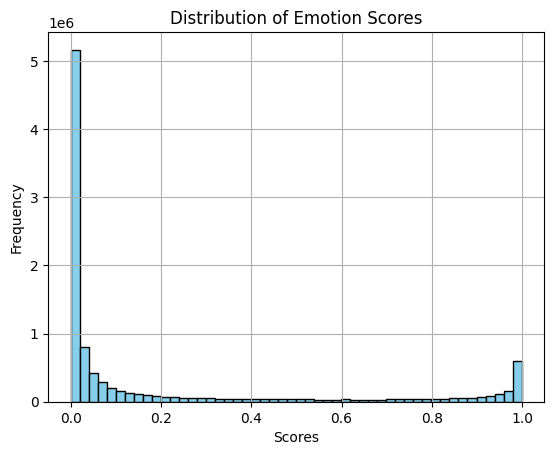

In [16]:
#Creating a histogram for the emotion scores
import matplotlib.pyplot as plt

plt.hist(flat_scores, bins=50, color='skyblue', edgecolor='black')  # Adjust bins as needed
plt.title('Distribution of Emotion Scores')
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [18]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


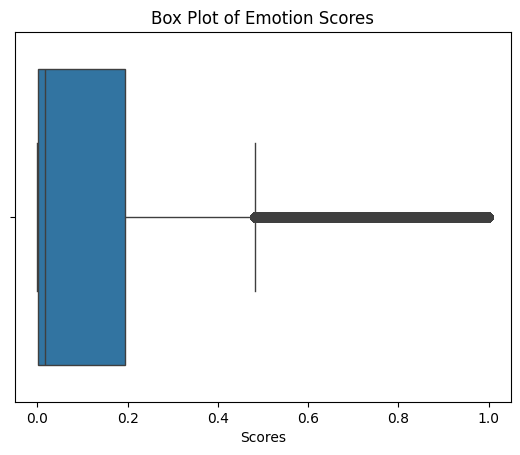

In [19]:
import seaborn as sns

# Create a box plot for the emotion scores
sns.boxplot(x=flat_scores)
plt.title('Box Plot of Emotion Scores')
plt.xlabel('Scores')
plt.show()